# Practical Machine Learning
by Sven Mayer

## 	Lecture 13: Evaluation Metrics

The material is licensed under the Creative Commons Attribution-Share Alike 4.0 (CC BY-SA) license: https://creativecommons.org/licenses/by-sa/4.0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
print("Python version: ", sys.version)
import numpy as np
print("numpy version", np.__version__)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
print("matplotlib version", matplotlib.__version__)
import tensorflow as tf
print("TF:", tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if (len(physical_devices) > 0):
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("TF: No GPU found")

import pandas as pd

from tqdm import tqdm

Python version:  3.9.1 (default, Jan  8 2021, 17:17:17) 
[Clang 12.0.0 (clang-1200.0.32.28)]
numpy version 1.19.5
matplotlib version 3.3.3
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
TF: 2.5.0-rc0
TF: No GPU found


(14662, 20, 20, 1) (14662, 2)
(6342, 20, 20, 1) (6342, 2)
(20, 20, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 18, 18, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
HiddenLayer1 (Dense)         (None, 64)                165952    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
____________________________________________________

Epoch 49/50
459/459 [==============================] - 2s 5ms/step - loss: 0.1373 - accuracy: 0.9534 - val_loss: 0.3168 - val_accuracy: 0.8901
Epoch 50/50
459/459 [==============================] - 2s 5ms/step - loss: 0.1328 - accuracy: 0.9548 - val_loss: 0.4138 - val_accuracy: 0.8680


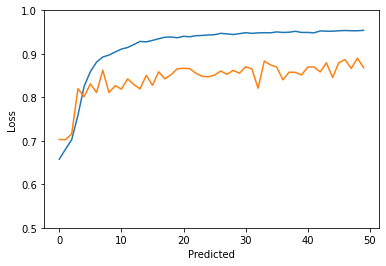

In [2]:
df = pd.read_pickle("./dataKnckleTouch/knuckletouch_only3ps.pkl")

dfTrain = df[df.userID.isin([1,2])]
dfValidation = df[df.userID.isin([3])]

###
x_train = np.stack(dfTrain.Blob1D.to_list()).reshape((-1, 20,20,1))
y_train = np.stack(dfTrain.Label.to_list())
print(x_train.shape, y_train.shape)

x_val = np.stack(dfValidation.Blob1D.to_list()).reshape((-1, 20,20,1))
y_val = np.stack(dfValidation.Label.to_list())
print(x_val.shape, y_val.shape)

input_size = x_val.shape[1:]
print(input_size)

def getModel():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.InputLayer(input_size, name = "InputLayer"))
    
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), name = "Conv1", activation='relu'))
    
    model.add(tf.keras.layers.MaxPool2D())
    
    model.add(tf.keras.layers.Dropout(.5))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, name = "HiddenLayer1", activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Dense(2, name = "OutputLayer", activation='softmax'))
    return model



model = getModel()

model.summary()

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
lossFunction = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=lossFunction, metrics=['accuracy'])
history = model.fit(x_train, y_train,
                validation_data = (x_val, y_val),
                epochs=50,
                verbose=1)

plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")

plt.ylim(0.5, 1)
#plt.text (0.1,.9, f"$lr={learning_rate}$", size=12)
plt.xlabel('Predicted')
plt.ylabel('Loss')
plt.show()

In [3]:
%%time
#y_train_pred = []
#bs = 128
#for i in range(0, len(dfTrain), bs):
#    y_train_pred.extend(model.predict(x_train[i:i+bs]))
    
y_val_pred = []
bs = 128
for i in range(0, len(dfValidation), bs):
    y_val_pred.extend(model.predict(x_val[i:i+bs]))

CPU times: user 1.87 s, sys: 169 ms, total: 2.04 s
Wall time: 1.47 s


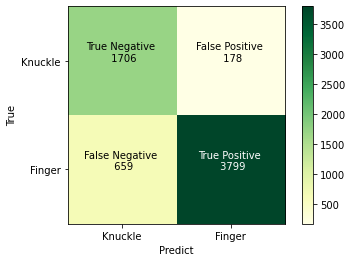

In [5]:
y_val_c = list(np.argmax(y_val, axis=1))
y_val_c = list(map(lambda x: "Knuckle" if x == 1 else "Finger",  y_val_c))
            
y_val_pred_c = list(np.argmax(y_val_pred, axis=1))
y_val_pred_c = list(map(lambda x: "Knuckle" if x == 1 else "Finger",  y_val_pred_c))
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y_val_c, y_val_pred_c, labels=["Knuckle", "Finger"])
tn, fp, fn, tp = c.ravel()
    
plt.imshow(c, cmap="YlGn")
plt.ylabel("True")
plt.xlabel("Predict")
plt.text(0,0,f"True Negative \n {tn}", ha="center")
plt.text(1,0,f"False Positive \n {fp}", ha="center")
plt.text(0,1,f"False Negative \n {fn}", ha="center")
plt.text(1,1,f"True Positive \n {tp}", ha="center", c="w")
plt.yticks([0,1], ["Knuckle", "Finger"])
plt.xticks([0,1], ["Knuckle", "Finger"])
plt.colorbar()
plt.savefig("./figures/13_cm_bin.png", dpi=500, bbox_inches = 'tight', pad_inches = 0)
plt.show()

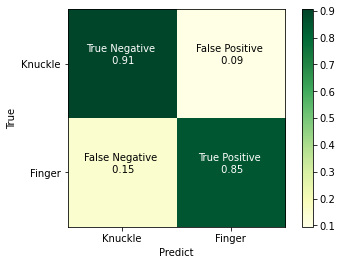

In [8]:
y_val_c = list(np.argmax(y_val, axis=1))
y_val_c = list(map(lambda x: "Knuckle" if x == 1 else "Finger",  y_val_c))
            
y_val_pred_c = list(np.argmax(y_val_pred, axis=1))
y_val_pred_c = list(map(lambda x: "Knuckle" if x == 1 else "Finger",  y_val_pred_c))
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y_val_c, y_val_pred_c, labels=["Knuckle", "Finger"], normalize = "true")
tn, fp, fn, tp = c.ravel()
    
plt.imshow(c, cmap="YlGn")
plt.ylabel("True")
plt.xlabel("Predict")
plt.text(0,0,f"True Negative \n {np.round(tn,2)}", ha="center", c="w")
plt.text(1,0,f"False Positive \n {np.round(fp,2)}", ha="center")
plt.text(0,1,f"False Negative \n {np.round(fn,2)}", ha="center")
plt.text(1,1,f"True Positive \n {np.round(tp,2)}", ha="center", c="w")
plt.yticks([0,1], ["Knuckle", "Finger"])
plt.xticks([0,1], ["Knuckle", "Finger"])
plt.colorbar()
plt.savefig("./figures/13_cm_bin_normed.png", dpi=500, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [9]:
y_val_c = list(np.argmax(y_val, axis=1))
y_val_pred_c = list(np.argmax(y_val_pred, axis=1))

In [10]:
p = tp/(tp + fp)
r = tp/(tp + fn)
f1 = 2 * ((p*r)/(p+r))
accuracy = (tp + tn) / (tn + fp + fn + tp)
print("Presiciton", p)
print("Recall", r)
print("F1 Score", f1)
print("Accuracy" ,accuracy)

Presiciton 0.9001962056839278
Recall 0.8521758636159713
F1 Score 0.8755280826965026
Accuracy 0.8788480167336756


# Multi Label

In [11]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28)[:30000,:]
x_val = x_val.reshape(-1, 28*28)[:5000,:]
y_train = tf.keras.utils.to_categorical(y_train)[:30000,:]
y_val = tf.keras.utils.to_categorical(y_val)[:5000,:]
input_size = x_val.shape[-1]
output_size = y_val.shape[-1]
print(input_size, output_size)

784 10


In [12]:
def getModel():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.InputLayer((input_size,), name = "InputLayer"))

    model.add(tf.keras.layers.Dense(256, name = "HiddenLayer1", activation = 'relu')) 
    model.add(tf.keras.layers.Dropout(.5)) 

    model.add(tf.keras.layers.Dense(128, name = "HiddenLayer2", activation = 'relu')) 
    model.add(tf.keras.layers.Dropout(.5)) 

    model.add(tf.keras.layers.Dense(output_size, name = "OutputLayer", activation = 'softmax'))
    return model

model = getModel()
model.summary()

lossFunction = tf.keras.losses.CategoricalCrossentropy()
model = getModel()
model.compile(optimizer="adam", loss=lossFunction, metrics=['accuracy'])
history = model.fit(x_train, y_train,
                validation_data = (x_val, y_val),
                epochs=25,
                   verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (Dense)         (None, 256)               200960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
HiddenLayer2 (Dense)         (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
OutputLayer (Dense)          (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
938/938 [==============================] - 2s 1ms/step - loss: 23.2819 - accuracy: 0.3983 - val_loss: 1

In [13]:
%%time
y_val_pred = []
bs = 128
for i in range(0, len(x_val), bs):
    y_val_pred.extend(model.predict(x_val[i:i+bs]))

CPU times: user 1.24 s, sys: 48.2 ms, total: 1.29 s
Wall time: 1.18 s


In [14]:
y_val_c = list(np.argmax(y_val, axis=1))   
y_val_pred_c = list(np.argmax(y_val_pred, axis=1))   

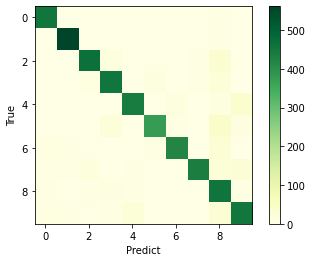

In [15]:
c = confusion_matrix(y_val_c, y_val_pred_c)
    
plt.imshow(c, cmap="YlGn")
plt.ylabel("True")
plt.xlabel("Predict")
plt.colorbar()
plt.savefig("./figures/13_cm_MNIST.png", dpi=500, bbox_inches = 'tight', pad_inches = 0)
plt.show()